<a href="https://colab.research.google.com/github/Strojove-uceni/final-projects-i_am_not_a_robot/blob/main/captcha_basic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libraries

In [1]:
# install and load packages
! pip install patool
! pip install pyunpack

import argparse
import os
import random
import requests
import zipfile
import errno
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyunpack import Archive
import glob
import string
from PIL import Image
from tqdm import tqdm
import torch.nn.functional 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

     |████████████████████████████████| 77 kB 2.4 MB/s 


# Connect and download data from Disk

In [2]:
# connect to google drive for saving models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# new
# download files from google drive

# load train data
#!gdown --id 1zt8NIVLGSxoGrlGd-BoGehK9DLwEMPTD - old

!gdown --id  1qD467j_vB4cnOgHTRPqmbiCZOagWGG-8

# load test data
#!gdown --id 18qEmkB012SLsWLrvxcAnhH_uiuhBZ9C4
!gdown --id 1mztCnyTG_1nFKgnaF7dFKOPJXdgjeu7E


Downloading...
From: https://drive.google.com/uc?id=1qD467j_vB4cnOgHTRPqmbiCZOagWGG-8
To: /content/captcha_train.tar.gz
100% 1.27G/1.27G [00:12<00:00, 100MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1mztCnyTG_1nFKgnaF7dFKOPJXdgjeu7E
To: /content/captcha_test.tar.gz
100% 254M/254M [00:04<00:00, 56.7MB/s]


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_cudas = torch.cuda.device_count()

print(f'We are now using {device}. There are {n_cudas} available gpus.')

if torch.cuda.is_available():
    print(f'{torch.cuda.get_device_name(0)}')

We are now using cuda. There are 1 available gpus.
Tesla K80


In [5]:
# create folders to unzip data
! mkdir 'train'
! mkdir 'test'

# unzip data
Archive('captcha_train.tar.gz').extractall('train')
Archive('captcha_test.tar.gz').extractall('test')

In [6]:
# check number of files
train_labels = os.listdir('train/train')
print('train files:', len(train_labels))

test_labels = os.listdir('test/test')
print('test files:', len(test_labels))

train files: 200711
test files: 40000


# Check the dataset

In [7]:
captcha_len = 4

In [8]:
# check distribution of symbols in train set

# these are all symbols the captchas will have
symbols = string.ascii_uppercase + string.ascii_lowercase + string.digits  

symbols_help = string.ascii_lowercase + string.digits 
index = {}
for cha in symbols_help:
  index[cha] = 0


In [9]:
for item in train_labels:
  get_label = str(item).split('.')[0]
  for cha in get_label:
    index[cha] += 1

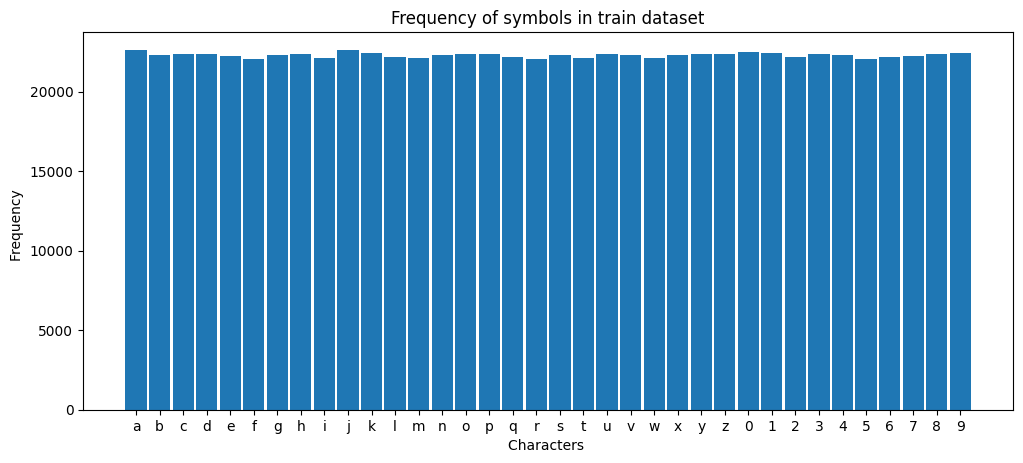

In [10]:
plt.figure(num=None, figsize=(12, 5), dpi=100, facecolor='w', edgecolor='k')
plt.bar(index.keys(), index.values(), width=0.9)
plt.title('Frequency of symbols in train dataset')
plt.xlabel("Characters ", fontsize=10)  
plt.ylabel("Frequency  ", fontsize=10)
plt.show()

# Setup for model

In [11]:
workers = 2                           # worker threads for loading the data with the DataLoader
batch_size = 256                      # size of batch
image_size = [60, 120]                # size of imput images
nc = 3                                # number of color channels in the input images

# normalization parameters
normalize_mean = (0.485, 0.456, 0.406)
normalize_std = (0.229, 0.224, 0.225)

# for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [12]:
class Custom_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, data_dir, data_labels):
        self.data_dir = data_dir
        self.data_labels = data_labels
        
    def __len__(self):
        return len(self.data_labels)
    
    def __getitem__(self, index):
        image_label = self.data_labels[index]
        image_fp = os.path.join(self.data_dir, image_label)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_label.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ])
        return transform_ops(image)

In [13]:
# create dataloaders

dataset_train = Custom_Dataset('train/train', train_labels) 
dataset_test = Custom_Dataset('test/test', test_labels)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, num_workers=workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, num_workers=workers, shuffle=False)

print(len(train_loader), len(test_loader))

785 157


In [14]:
# check dimensions
print(len(train_labels)/batch_size, len(test_labels)/batch_size)
# decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

784.02734375 156.25


In [15]:
def UnNormalizeBatch(batch):
    for i in range(batch.shape[3]):
       batch[:,:,:,i] = (batch[:,:,:,i] * normalize_std[i]) + normalize_mean[i]

    return batch

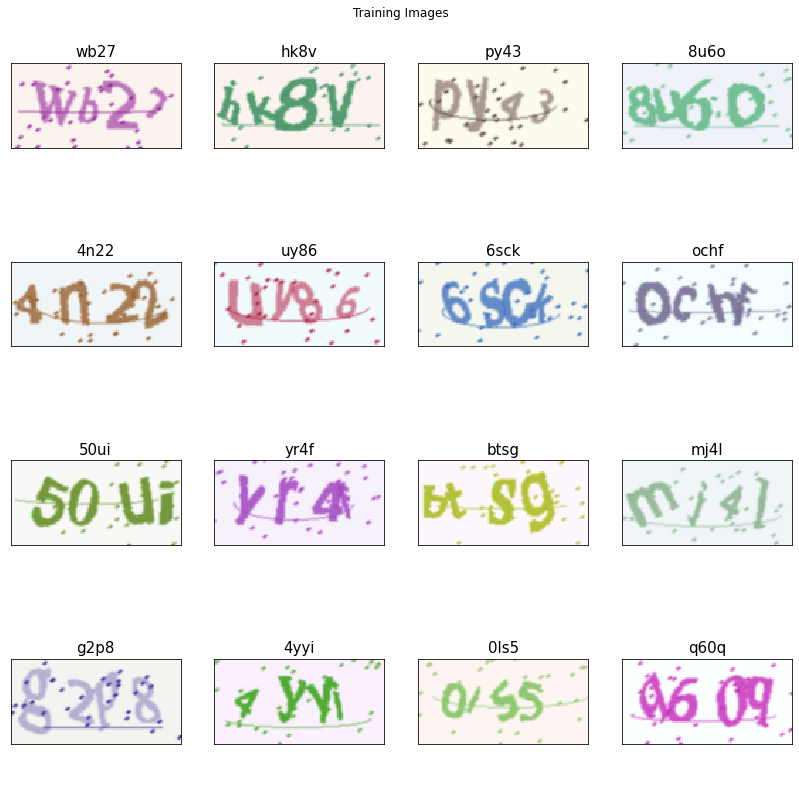

In [16]:
# view some train images
real_batch = next(iter(train_loader))
real_batch_pictures = np.transpose(real_batch[0].to(device).cpu().detach().numpy(),(0,2,3,1))
real_batch_pictures = UnNormalizeBatch(real_batch_pictures)

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Training Images")

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(real_batch_pictures[i], interpolation='nearest')
    plt.title(real_batch[1][i], color='k', fontsize=15)

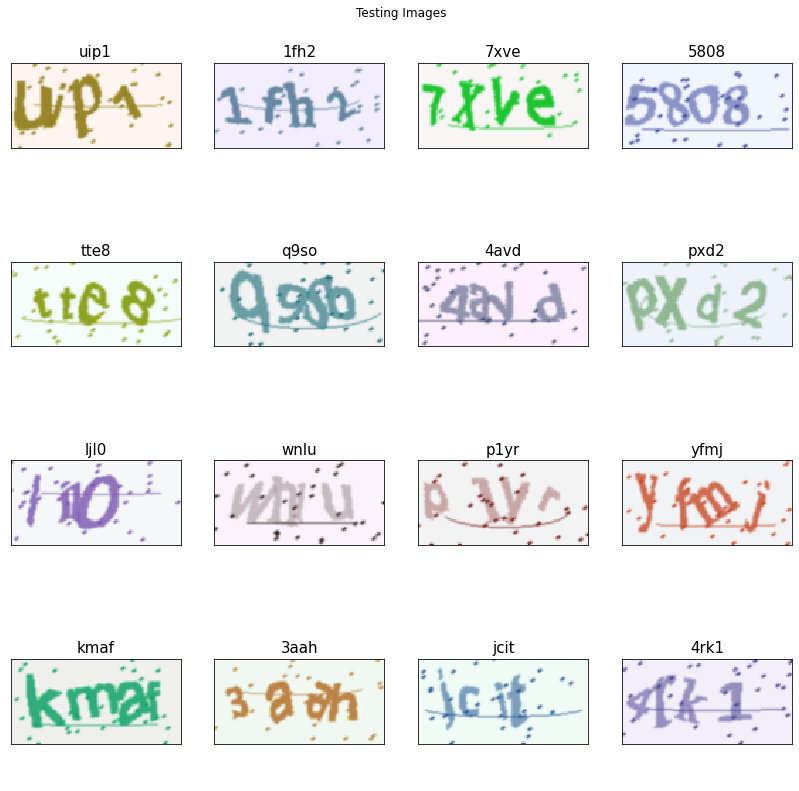

In [17]:
# view some test images
real_batch = next(iter(test_loader))
real_batch_pictures = np.transpose(real_batch[0].to(device).cpu().detach().numpy(),(0,2,3,1))
real_batch_pictures = UnNormalizeBatch(real_batch_pictures)

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Testing Images")

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(real_batch_pictures[i], interpolation='nearest')
    plt.title(real_batch[1][i], color='k', fontsize=15)

In [18]:
symbols_char = {k:v for k,v in enumerate(symbols, start=0)}
symbols_idx = {v:k for k,v in symbols_char.items()}
num_symbols = len(symbols_idx)

# Model

In [19]:
rnn_hidden_size = 256
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [20]:
class CTC(nn.Module):
    
    def __init__(self, num_symbols, rnn_hidden_size=256, dropout=0.1):
        
        super(CTC, self).__init__()
        self.num_chars = num_symbols
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2 - for resnet18
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)

        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_symbols)
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [22]:
ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)
ctc

CTC(
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [23]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([256, 3, 60, 120]) ('e7lo', '9kwe', 'zn5t', '6wcn', 'x187', 'lrhf', 'gzhi', 'ifqw', '0ru0', 'i0i5', 'kzxx', '02dh', 're76', 'kxlb', 'kcvb', 'xt20', '2qsf', '9nl9', 'o2a7', 'rkuf', 'tuic', 's894', 'n1cp', '0an1', '60s0', 'fpl2', 'eueh', '2dy6', 'qw08', '1pzh', 'bnsy', '78g6', 'i2lh', 'atqc', 'z1p3', '17j3', 'sen0', '4x7j', '2l04', '0jv8', 'o9cn', 's7h7', 'n159', 'qp5u', 'tpo8', 'cv0f', 'mixc', '16p9', 'p29h', 'o8x4', 'm4tv', 'q2kl', 'gjz5', '3nn5', '51vp', 'e1qe', '1ves', '7o4d', '76ky', 'xy4w', 'um6h', 'p06t', 'eq9m', 'ttxk', 'a5nq', 'gc61', 'gb7b', 'grfq', 'qeyo', 'qbtx', 'i21x', '53r1', 'tt05', 'v86w', 'zk6t', 'pgw0', 'q3vc', 'mnmi', '5u1d', '5gg8', 's2ko', '5rjr', '45d2', '9o6e', '6ftr', 'ap8k', 'd792', 'jfpk', 'htw5', 'ffrv', '8arr', 'm55j', 's35z', '1zmy', '9oa2', 'iiob', '2ug1', 'o5g9', '45ss', '8sfo', 'hk19', '81w7', 'c4hq', 'm34n', '9oaj', 'xb2u', 'ek07', 'un7v', 'ak83', 'g5t6', '9zxi', '9ykr', 'nvsh', '1ayw', 'xxvj', 'ling', 'i2ma', 'kaup', 'zrky', 'o2yx', 'dwzn', '

In [24]:
text_batch_logits = ctc(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('e7lo', '9kwe', 'zn5t', '6wcn', 'x187', 'lrhf', 'gzhi', 'ifqw', '0ru0', 'i0i5', 'kzxx', '02dh', 're76', 'kxlb', 'kcvb', 'xt20', '2qsf', '9nl9', 'o2a7', 'rkuf', 'tuic', 's894', 'n1cp', '0an1', '60s0', 'fpl2', 'eueh', '2dy6', 'qw08', '1pzh', 'bnsy', '78g6', 'i2lh', 'atqc', 'z1p3', '17j3', 'sen0', '4x7j', '2l04', '0jv8', 'o9cn', 's7h7', 'n159', 'qp5u', 'tpo8', 'cv0f', 'mixc', '16p9', 'p29h', 'o8x4', 'm4tv', 'q2kl', 'gjz5', '3nn5', '51vp', 'e1qe', '1ves', '7o4d', '76ky', 'xy4w', 'um6h', 'p06t', 'eq9m', 'ttxk', 'a5nq', 'gc61', 'gb7b', 'grfq', 'qeyo', 'qbtx', 'i21x', '53r1', 'tt05', 'v86w', 'zk6t', 'pgw0', 'q3vc', 'mnmi', '5u1d', '5gg8', 's2ko', '5rjr', '45d2', '9o6e', '6ftr', 'ap8k', 'd792', 'jfpk', 'htw5', 'ffrv', '8arr', 'm55j', 's35z', '1zmy', '9oa2', 'iiob', '2ug1', 'o5g9', '45ss', '8sfo', 'hk19', '81w7', 'c4hq', 'm34n', '9oaj', 'xb2u', 'ek07', 'un7v', 'ak83', 'g5t6', '9zxi', '9ykr', 'nvsh', '1ayw', 'xxvj', 'ling', 'i2ma', 'kaup', 'zrky', 'o2yx', 'dwzn', '0uvx', 'i67o', '18jb', 'q3o4',

In [25]:
criterion = nn.CTCLoss(blank=0)

In [26]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [symbols_idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [27]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = torch.nn.functional.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [28]:
text_batch_logits.shape

torch.Size([5, 256, 62])

In [29]:
compute_loss(text_batch, text_batch_logits)

tensor(4.6290, device='cuda:0', grad_fn=<MeanBackward0>)

Train model

In [31]:
num_epochs =20
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [32]:
optimizer = optim.Adam(ctc.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [33]:
ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

In [34]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []

help_const = 0

for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in train_loader:
        optimizer.zero_grad()
        text_batch_logits = ctc(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(ctc.parameters(), clip_norm)
        optimizer.step()

        help_const = help_const + 1
        if (help_const % 100 == 0):
            print("Batch:{}    Loss:{}".format(help_const, np.mean(epoch_loss_list)))

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

    help_const = 0

  0%|          | 0/20 [00:00<?, ?it/s]

Batch:100    Loss:3.785282199382782
Batch:200    Loss:3.24486034154892
Batch:300    Loss:2.926946237881978
Batch:400    Loss:2.7290290421247483
Batch:500    Loss:2.595236113071442
Batch:600    Loss:2.4962744839986164
Batch:700    Loss:2.4217060118062155


  5%|▌         | 1/20 [06:09<1:57:08, 369.93s/it]

Epoch:1    Loss:2.3702264073548043    NumUpdates:785
Batch:100    Loss:1.9335328125953675
Batch:200    Loss:1.9223102974891662
Batch:300    Loss:1.9147759592533111
Batch:400    Loss:1.9062735396623611
Batch:500    Loss:1.8989408836364745
Batch:600    Loss:1.892980503241221
Batch:700    Loss:1.8860752141475678


 10%|█         | 2/20 [12:19<1:50:57, 369.85s/it]

Epoch:2    Loss:1.8816984149301128    NumUpdates:785
Batch:100    Loss:1.8518853211402893
Batch:200    Loss:1.8368980610370635
Batch:300    Loss:1.8304553353786468
Batch:400    Loss:1.8281201118230819
Batch:500    Loss:1.8242173407077789
Batch:600    Loss:1.8218422486384709
Batch:700    Loss:1.819193079812186


 15%|█▌        | 3/20 [18:29<1:44:44, 369.70s/it]

Epoch:3    Loss:1.8174408277888208    NumUpdates:785
Batch:100    Loss:1.8008977270126343
Batch:200    Loss:1.798817167878151
Batch:300    Loss:1.7991973249117534
Batch:400    Loss:1.796141999065876
Batch:500    Loss:1.7934647006988524
Batch:600    Loss:1.792533732453982
Batch:700    Loss:1.7902337944507598


 20%|██        | 4/20 [24:38<1:38:33, 369.56s/it]

Epoch:4    Loss:1.7894482188923344    NumUpdates:785
Batch:100    Loss:1.7880836391448975
Batch:200    Loss:1.7796538698673248
Batch:300    Loss:1.7807106173038483
Batch:400    Loss:1.7783012434840202
Batch:500    Loss:1.778057265996933
Batch:600    Loss:1.777601954539617
Batch:700    Loss:1.7785767832824162


 25%|██▌       | 5/20 [30:47<1:32:21, 369.43s/it]

Epoch:5    Loss:1.7773831979484316    NumUpdates:785
Batch:100    Loss:1.7831938195228576
Batch:200    Loss:1.772175567150116
Batch:300    Loss:1.768342342376709
Batch:400    Loss:1.7666484832763671
Batch:500    Loss:1.766671982049942
Batch:600    Loss:1.7657560263077419
Batch:700    Loss:1.7647524363654001


 30%|███       | 6/20 [36:56<1:26:08, 369.14s/it]

Epoch:6    Loss:1.7654075233799638    NumUpdates:785
Batch:100    Loss:1.782512389421463
Batch:200    Loss:1.7665631037950515
Batch:300    Loss:1.7618800055980683
Batch:400    Loss:1.760273787677288
Batch:500    Loss:1.7612255306243896
Batch:600    Loss:1.760774120291074
Batch:700    Loss:1.759691254070827


 35%|███▌      | 7/20 [43:04<1:19:54, 368.77s/it]

Epoch:7    Loss:1.7587051253409902    NumUpdates:785
Batch:100    Loss:1.7597626233100891
Batch:200    Loss:1.7539163637161255
Batch:300    Loss:1.7512803570429485
Batch:400    Loss:1.7500640487670898
Batch:500    Loss:1.750013334751129
Batch:600    Loss:1.751021499435107
Batch:700    Loss:1.7525552402223858


 40%|████      | 8/20 [49:11<1:13:39, 368.32s/it]

Epoch:8    Loss:1.7522426448809874    NumUpdates:785
Batch:100    Loss:1.7570288789272308
Batch:200    Loss:1.7497275203466416
Batch:300    Loss:1.7479227662086487
Batch:400    Loss:1.7472150287032127
Batch:500    Loss:1.7479025256633758
Batch:600    Loss:1.7468285652001698
Batch:700    Loss:1.7460801127978733


 45%|████▌     | 9/20 [55:18<1:07:26, 367.86s/it]

Epoch:9    Loss:1.7452783639263956    NumUpdates:785
Batch:100    Loss:1.7473828887939453
Batch:200    Loss:1.7449272364377975
Batch:300    Loss:1.7420657420158385
Batch:400    Loss:1.742101399600506
Batch:500    Loss:1.74094611287117
Batch:600    Loss:1.7429277247190476
Batch:700    Loss:1.7427524157932825


 50%|█████     | 10/20 [1:01:24<1:01:13, 367.39s/it]

Epoch:10    Loss:1.7428542064253691    NumUpdates:785
Batch:100    Loss:1.746486678123474
Batch:200    Loss:1.740969244837761
Batch:300    Loss:1.7414446226755778
Batch:400    Loss:1.739249893128872
Batch:500    Loss:1.737872918844223
Batch:600    Loss:1.7377980029582978
Batch:700    Loss:1.7390125911576406


 55%|█████▌    | 11/20 [1:07:30<55:02, 366.95s/it]  

Epoch:11    Loss:1.7396259368604916    NumUpdates:785
Batch:100    Loss:1.7378562605381012
Batch:200    Loss:1.7374057692289353
Batch:300    Loss:1.7369578564167023
Batch:400    Loss:1.7360218077898026
Batch:500    Loss:1.7383208363056182
Batch:600    Loss:1.737028174797694
Batch:700    Loss:1.73762027995927


 60%|██████    | 12/20 [1:13:36<48:51, 366.45s/it]

Epoch:12    Loss:1.738800545862526    NumUpdates:785
Batch:100    Loss:1.7344022953510285
Batch:200    Loss:1.7310665094852447
Batch:300    Loss:1.7307327322165171
Batch:400    Loss:1.7317344585061074
Batch:500    Loss:1.7325054559707642
Batch:600    Loss:1.7323059044281641
Batch:700    Loss:1.7317287509781973


 65%|██████▌   | 13/20 [1:19:40<42:41, 365.92s/it]

Epoch:13    Loss:1.7329572871991783    NumUpdates:785
Batch:100    Loss:1.731074699163437
Batch:200    Loss:1.7299119329452515
Batch:300    Loss:1.7292754964033763
Batch:400    Loss:1.728982515335083
Batch:500    Loss:1.7304094171524047
Batch:600    Loss:1.7331957574685415
Batch:700    Loss:1.731158982174737


 70%|███████   | 14/20 [1:25:44<36:32, 365.36s/it]

Epoch:14    Loss:1.731558913637878    NumUpdates:785
Batch:100    Loss:1.7416939234733582
Batch:200    Loss:1.7335034823417663
Batch:300    Loss:1.734253343741099
Batch:400    Loss:1.735387899875641
Batch:500    Loss:1.7349018428325653
Batch:600    Loss:1.7323262174924214
Batch:700    Loss:1.7326052355766297


 75%|███████▌  | 15/20 [1:31:48<30:24, 364.86s/it]

Epoch:15    Loss:1.7319941894263977    NumUpdates:785
Batch:100    Loss:1.740212310552597
Batch:200    Loss:1.732971678376198
Batch:300    Loss:1.731618047952652
Batch:400    Loss:1.7352955090999602
Batch:500    Loss:1.7358421883583068
Batch:600    Loss:1.7349059869845709
Batch:700    Loss:1.7337562486103604


 80%|████████  | 16/20 [1:37:51<24:17, 364.35s/it]

Epoch:16    Loss:1.7334356550957746    NumUpdates:785
Batch:100    Loss:1.7278530478477478
Batch:200    Loss:1.7243708097934722
Batch:300    Loss:1.7263877220948538
Batch:400    Loss:1.728472563326359
Batch:500    Loss:1.7272066779136657
Batch:600    Loss:1.7280768316984176
Batch:700    Loss:1.7278386393615177


 85%|████████▌ | 17/20 [1:43:54<18:11, 363.93s/it]

Epoch:17    Loss:1.727964200639421    NumUpdates:785
Batch:100    Loss:1.7285706400871277
Batch:200    Loss:1.7240319192409514
Batch:300    Loss:1.721047692298889
Batch:400    Loss:1.7238713443279265
Batch:500    Loss:1.728459216117859
Batch:600    Loss:1.7286603903770448
Batch:700    Loss:1.7302081414631434


 90%|█████████ | 18/20 [1:49:57<12:07, 363.64s/it]

Epoch:18    Loss:1.7289441157298482    NumUpdates:785
Batch:100    Loss:1.725587966442108
Batch:200    Loss:1.7219086354970932
Batch:300    Loss:1.7209783168633779
Batch:400    Loss:1.7239861246943473
Batch:500    Loss:1.7254483489990233
Batch:600    Loss:1.7246285382906597
Batch:700    Loss:1.7244438242912292


 95%|█████████▌| 19/20 [1:56:00<06:03, 363.29s/it]

Epoch:19    Loss:1.7245665515304371    NumUpdates:785
Batch:100    Loss:1.7323179161548614
Batch:200    Loss:1.7229740142822265
Batch:300    Loss:1.726503943602244
Batch:400    Loss:1.7247646942734718
Batch:500    Loss:1.7253865265846253
Batch:600    Loss:1.7246525659163794
Batch:700    Loss:1.7247097301483154


100%|██████████| 20/20 [2:02:02<00:00, 366.12s/it]

Epoch:20    Loss:1.723860249397861    NumUpdates:785


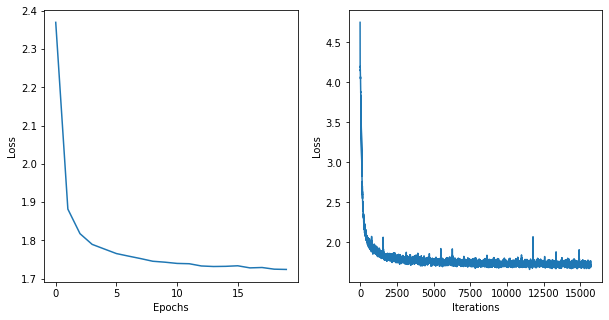

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

# Predictions

In [36]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = torch.nn.functional.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [symbols_char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [53]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
# train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = ctc(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

100%|██████████| 785/785 [04:14<00:00,  3.08it/s]


In [54]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
# test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = ctc(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

100%|██████████| 157/157 [00:48<00:00,  3.23it/s]


In [59]:
print(results_train.shape)
results_train.head()

(200711, 3)


,actual,prediction,prediction_corrected
0,khwd,khhwd,khwd
1,14dn,14ddn,14dn
2,ic3m,jccmm,jcm
3,ovo8,ovvo8,ovo8
4,cks1,ckss1,cks1


In [60]:
print(results_test.shape)
results_test.head()

(40000, 2)


,actual,prediction
0,uip1,ujpp1
1,1fh2,1fhh2
2,7xve,7xxee
3,5808,58808
4,tte8,ttee8


Correct predictions

In [61]:
def remove_duplicates(text):
    if len(text) > 4:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 4:
        letters = [text[0:4]]
    elif len(text) == 3:
        letters = [text[0:3]]
    elif len(text) == 2:
        letters = [text[0:2]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    corrected_word = corrected_word[0:4]
    return corrected_word

In [62]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,khwd,khhwd,khwd
1,14dn,14ddn,14dn
2,ic3m,jccmm,jcm
3,ovo8,ovvo8,ovo8
4,cks1,ckss1,cks1


In [63]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,uip1,ujpp1,ujp1
1,1fh2,1fhh2,1fh2
2,7xve,7xxee,7xe
3,5808,58808,5808
4,tte8,ttee8,te8


Evaluate model

In [64]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
0,uip1,ujpp1,ujp1
2,7xve,7xxee,7xe
4,tte8,ttee8,te8
8,ljl0,ljj00,lj0
9,wnlu,wnnnu,wnu
...,...,...,...
39968,jsio,jiiio,jio
39969,ey66,ey666,ey6
39987,50cu,500uu,50u
39990,ht5d,hh55d,h5d


In [65]:
results_test

,actual,prediction,prediction_corrected
0,uip1,ujpp1,ujp1
1,1fh2,1fhh2,1fh2
2,7xve,7xxee,7xe
3,5808,58808,5808
4,tte8,ttee8,te8
...,...,...,...
39995,04dy,04ddy,04dy
39996,e65m,e665m,e65m
39997,8lgc,8lggc,8lgc
39998,cawa,caawa,cawa


In [67]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

3    5358
4    2209
2    1045
1      54
Name: prediction_corrected, dtype: int64


In [68]:
mask = mistakes_df['prediction_corrected'].str.len() == captcha_len
mistakes_df[mask]

,actual,prediction,prediction_corrected
0,uip1,ujpp1,ujp1
16,031y,o33ly,o3ly
22,p51e,p55ve,p5ve
60,p6tr,p66cr,p6cr
62,ozi4,ozzj4,ozj4
...,...,...,...
39887,nc0s,nccos,ncos
39910,7445,74A45,74A4
39946,jpcm,jppum,jpum
39960,iib8,illb8,ilb8


In [69]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print('Train accuracy: ', train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print('Test accuracy: ', test_accuracy)

Train accuracy:  0.7898720050221463
Test accuracy:  0.78335


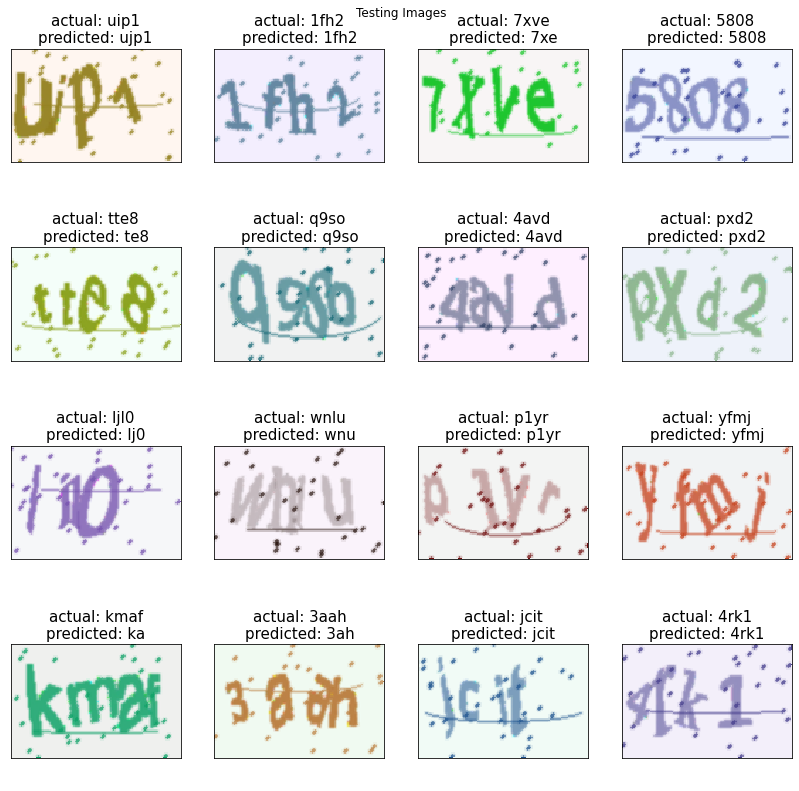

In [70]:
# view some test images and predictions

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Testing Images")

for i in range(16):
    result = results_test.iloc[i]
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img = mpimg.imread('test/test/{}.png'.format(result[0]))
    ax.imshow(img, interpolation='nearest')
    plt.title('actual: ' + result[0] + '\n' + 'predicted: ' + result[2], color='k', fontsize=15)

In [71]:
! pip install textdistance

from textdistance import ratcliff_obershelp

In [73]:
for i in tqdm(range(len(results_train))):
    results_train['ratcliff_obershelp'] = ratcliff_obershelp(results_train.iloc[i,0], results_train.iloc[i,2])

100%|██████████| 200711/200711 [02:48<00:00, 1193.46it/s]


In [72]:
for i in tqdm(range(len(results_test))):
    results_test['ratcliff_obershelp'] = ratcliff_obershelp(results_test.iloc[i,0], results_test.iloc[i,2])

100%|██████████| 40000/40000 [00:34<00:00, 1150.63it/s]


In [75]:
print('Train Ratcliff-Obershelp: ', results_train['ratcliff_obershelp'].mean())
print('Test Ratcliff-Obershelp: ', results_test['ratcliff_obershelp'].mean())

Train Ratcliff-Obershelp:  1.0
Test Ratcliff-Obershelp:  1.0


In [76]:
PATH = "/content/drive/MyDrive/model_basic_resnet18_5_v2.pt"
torch.save(ctc.state_dict(), PATH)